In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['items.csv', 'sample_submission.csv', 'test.csv', 'sales_train.csv', 'item_categories.csv', 'shops.csv']


In [2]:
path = '../input/'
test = pd.read_csv(path + 'test.csv')
train = pd.read_csv(path + 'sales_train.csv')

# light version
- 안 좋음

In [3]:
shops = pd.read_csv(path + 'shops.csv')
items = pd.read_csv(path + 'items.csv')
item_categories = pd.read_csv(path + 'item_categories.csv')
items = pd.merge(items, item_categories, how = 'left')

del item_categories

train['date'] = pd.to_datetime(train.date,format = '%d.%m.%Y')
train['year'] = train.date.dt.year
train['month'] = train.date.dt.month
train['day'] = train.date.dt.day
train['weekday'] = train.date.dt.weekday #(Mon = 0 ~ Sun = 6)
train['revenue'] = train['item_price'] *  train['item_cnt_day']

shops['shop_len'] = shops.shop_name.apply(lambda x: str.replace(x, '!', '')).apply(lambda x: x.split(' ')).apply(len) #name_length
shops['city'] = shops.shop_name.apply(lambda x: str.replace(x, '!', '')).apply(lambda x: x.split(' ')[0])
shops['city'] = pd.Categorical(shops.city).codes

items['category1']= items.item_category_name.apply(lambda x : x.split('-')[0])
items['category2']= items.item_category_name.apply(lambda x : x.split('-')[0]).apply(lambda x : x.split(' ')[0])

items['category1'] = pd.Categorical(items.category1).codes
items['category2'] = pd.Categorical(items.category2).codes

In [4]:
train = pd.merge(train, shops.drop('shop_name', axis = 1), how = 'left')
train = pd.merge(train, items.drop(['item_name', 'item_category_name'], axis = 1), how = 'left')
train.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day,weekday,revenue,shop_len,city,item_category_id,category1,category2
0,2013-01-02,0,59,22154,999.0,1.0,2013,1,2,2,999.0,3,30,37,11,7
1,2013-01-03,0,25,2552,899.0,1.0,2013,1,3,3,899.0,3,13,58,13,9
2,2013-01-05,0,25,2552,899.0,-1.0,2013,1,5,5,-899.0,3,13,58,13,9


In [5]:
train.reset_index(drop = True, inplace = True)
train.to_csv('my_train.csv', index = False)

In [6]:
test['date_block_num'] = 34
train_sub = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day':'sum'}).rename(columns = {'item_cnt_day' : 'item_cnt_month'}).reset_index()
y = train_sub.item_cnt_month
df = pd.concat([train_sub.drop('item_cnt_month', axis = 1),test.drop('ID', axis = 1)])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


# groupby

In [7]:
aa = train.groupby(['shop_id','item_id']).agg({'revenue':['sum','mean','std','nunique','median'],
                                        'item_price':['sum','mean','std','nunique','median']}).reset_index()
aa.columns = ['shop_id','item_id'] + ['_'.join(x) for x in aa.columns.ravel()[2:]]

aa.head(3)

,shop_id,item_id,revenue_sum,revenue_mean,revenue_std,revenue_nunique,revenue_median,item_price_sum,item_price_mean,item_price_std,item_price_nunique,item_price_median
0,0,30,8215.0,912.777778,594.201729,4,795.0,2385.0,265.0,0.0,1,265.0
1,0,31,4774.0,682.000000,423.540632,2,434.0,3038.0,434.0,0.0,1,434.0
2,0,32,3536.0,321.454545,115.413486,2,221.0,2431.0,221.0,0.0,1,221.0


In [8]:
df = pd.merge(df, aa, how = 'left')

In [9]:
df.head(3)

,date_block_num,item_id,shop_id,revenue_sum,revenue_mean,revenue_std,revenue_nunique,revenue_median,item_price_sum,item_price_mean,item_price_std,item_price_nunique,item_price_median
0,0,32,0,3536.0,321.454545,115.413486,2.0,221.0,2431.0,221.0,0.0,1.0,221.0
1,0,33,0,2082.0,347.000000,0.000000,1.0,347.0,2082.0,347.0,0.0,1.0,347.0
2,0,35,0,3705.0,308.750000,111.709953,2.0,247.0,2964.0,247.0,0.0,1.0,247.0


# New Features

In [10]:
train = pd.concat([train, pd.get_dummies(train['weekday'], prefix = 'weekday')], axis = 1)
train.drop('weekday', axis = 1, inplace = True)
train.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day,revenue,...,item_category_id,category1,category2,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,2013-01-02,0,59,22154,999.0,1.0,2013,1,2,999.0,...,37,11,7,0,0,1,0,0,0,0
1,2013-01-03,0,25,2552,899.0,1.0,2013,1,3,899.0,...,58,13,9,0,0,0,1,0,0,0
2,2013-01-05,0,25,2552,899.0,-1.0,2013,1,5,-899.0,...,58,13,9,0,0,0,0,0,1,0


In [11]:
dd = train.groupby('date_block_num')['weekday_0','weekday_1','weekday_2','weekday_3','weekday_4','weekday_5','weekday_6'].agg(['sum','mean']).reset_index()
dd.columns = ['date_block_num'] + ['date_block_' + x for x in ['_'.join(x) for x in dd.columns.ravel()[1:]]]
dd.head(3)

,date_block_num,date_block_weekday_0_sum,date_block_weekday_0_mean,date_block_weekday_1_sum,date_block_weekday_1_mean,date_block_weekday_2_sum,date_block_weekday_2_mean,date_block_weekday_3_sum,date_block_weekday_3_mean,date_block_weekday_4_sum,date_block_weekday_4_mean,date_block_weekday_5_sum,date_block_weekday_5_mean,date_block_weekday_6_sum,date_block_weekday_6_mean
0,0,11867.0,0.102576,13813.0,0.119397,17557.0,0.151759,17557.0,0.151759,15953.0,0.137894,20837.0,0.180111,18106.0,0.156504
1,1,10550.0,0.097134,11504.0,0.105917,12222.0,0.112528,13479.0,0.124101,17306.0,0.159336,24160.0,0.222441,19392.0,0.178542
2,2,10625.0,0.087559,11558.0,0.095248,12602.0,0.103851,14590.0,0.120234,20956.0,0.172695,28154.0,0.232012,22862.0,0.188402


In [12]:
ds = train.groupby(['date_block_num','shop_id'])['weekday_0','weekday_1','weekday_2','weekday_3','weekday_4','weekday_5','weekday_6'].agg(['sum','mean','var']).reset_index()
ds.columns = ['date_block_num','shop_id'] + ['block_shop_' + x for x in ['_'.join(x) for x in ds.columns.ravel()[2:]]]
ds.head(3)

,date_block_num,shop_id,block_shop_weekday_0_sum,block_shop_weekday_0_mean,block_shop_weekday_0_var,block_shop_weekday_1_sum,block_shop_weekday_1_mean,block_shop_weekday_1_var,block_shop_weekday_2_sum,block_shop_weekday_2_mean,...,block_shop_weekday_3_var,block_shop_weekday_4_sum,block_shop_weekday_4_mean,block_shop_weekday_4_var,block_shop_weekday_5_sum,block_shop_weekday_5_mean,block_shop_weekday_5_var,block_shop_weekday_6_sum,block_shop_weekday_6_mean,block_shop_weekday_6_var
0,0,0,603.0,0.125808,0.110004,643.0,0.134154,0.116181,536.0,0.111830,...,0.133877,733.0,0.152931,0.129570,870.0,0.181515,0.148598,645.0,0.134571,0.116486
1,0,1,248.0,0.092056,0.083613,373.0,0.138456,0.119330,313.0,0.116184,...,0.152603,316.0,0.117298,0.103577,563.0,0.208983,0.165370,375.0,0.139198,0.119867
2,0,2,113.0,0.105509,0.094465,130.0,0.121382,0.106748,165.0,0.154062,...,0.135566,187.0,0.174603,0.144252,162.0,0.151261,0.128501,141.0,0.131653,0.114427


In [13]:
dsi = train.groupby(['date_block_num','shop_id','item_id'])['weekday_0','weekday_1','weekday_2','weekday_3','weekday_4','weekday_5','weekday_6'].agg(['sum','mean','var']).reset_index()
dsi.columns = ['date_block_num','shop_id','item_id'] + ['block_shop_item' + x for x in ['_'.join(x) for x in dsi.columns.ravel()[3:]]]
dsi.head(3)

,date_block_num,shop_id,item_id,block_shop_itemweekday_0_sum,block_shop_itemweekday_0_mean,block_shop_itemweekday_0_var,block_shop_itemweekday_1_sum,block_shop_itemweekday_1_mean,block_shop_itemweekday_1_var,block_shop_itemweekday_2_sum,...,block_shop_itemweekday_3_var,block_shop_itemweekday_4_sum,block_shop_itemweekday_4_mean,block_shop_itemweekday_4_var,block_shop_itemweekday_5_sum,block_shop_itemweekday_5_mean,block_shop_itemweekday_5_var,block_shop_itemweekday_6_sum,block_shop_itemweekday_6_mean,block_shop_itemweekday_6_var
0,0,0,32,1,0.250000,0.250000,0,0.0,0.0,0,...,0.333333,1,0.25,0.25,0,0.0,0.0,0,0.0,0.0
1,0,0,33,1,0.333333,0.333333,0,0.0,0.0,0,...,0.333333,0,0.00,0.00,0,0.0,0.0,0,0.0,0.0
2,0,0,35,0,0.000000,NaN,0,0.0,NaN,0,...,NaN,0,0.00,NaN,0,0.0,NaN,0,0.0,NaN


In [14]:
df = pd.merge(df, dd, how = 'left')
df = pd.merge(df, ds, how = 'left')
df = pd.merge(df, dsi, how = 'left')

print(df.shape)

(1823324, 69)


In [15]:
df.reset_index(inplace = True, drop = True)

In [16]:
df.to_csv('df.csv', index = False)

# Cv

In [17]:
X_train = df[df.date_block_num < 30]
y_train = y[df[df.date_block_num < 30].index]
X_valid = df[(df.date_block_num >= 30) & (df.date_block_num < 34)]
y_valid = y[df[(df.date_block_num >= 30) & (df.date_block_num < 34)].index]

X_test = df[df.date_block_num == 34] #test data

print('train shape X : {} y : {}'.format(X_train.shape, y_train.shape))
print('valid shape X : {} y : {}'.format(X_valid.shape, y_valid.shape))
print('test shape X : {}'.format(X_test.shape))

train shape X : (1480902, 69) y : (1480902,)
valid shape X : (128222, 69) y : (128222,)
test shape X : (214200, 69)


# Modeling

In [18]:
import gc
del df
gc.collect()

218

## lightGBM

In [19]:
from lightgbm import LGBMRegressor
lgb = LGBMRegressor(n_jobs = -1, n_estimators = 500)

lgb.fit(X_train, y_train, eval_metric='rmse', eval_set=[(X_train, y_train), (X_valid, y_valid)],
       verbose = 20, early_stopping_rounds=20)

Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 13.081	training's rmse: 3.61676	valid_1's l2: 96.55	valid_1's rmse: 9.82599
[40]	training's l2: 8.90964	training's rmse: 2.9849	valid_1's l2: 89.055	valid_1's rmse: 9.43689
[60]	training's l2: 7.43014	training's rmse: 2.72583	valid_1's l2: 87.1455	valid_1's rmse: 9.33517
[80]	training's l2: 6.56487	training's rmse: 2.5622	valid_1's l2: 85.2111	valid_1's rmse: 9.23098
[100]	training's l2: 5.93906	training's rmse: 2.43702	valid_1's l2: 84.2109	valid_1's rmse: 9.17665
[120]	training's l2: 5.43468	training's rmse: 2.33124	valid_1's l2: 83.3295	valid_1's rmse: 9.1285
[140]	training's l2: 5.06791	training's rmse: 2.2512	valid_1's l2: 82.178	valid_1's rmse: 9.06521
[160]	training's l2: 4.69719	training's rmse: 2.1673	valid_1's l2: 82.0017	valid_1's rmse: 9.05548
[180]	training's l2: 4.40104	training's rmse: 2.09787	valid_1's l2: 81.791	valid_1's rmse: 9.04384
[200]	training's l2: 4.1171	training's rmse: 2.02906	

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

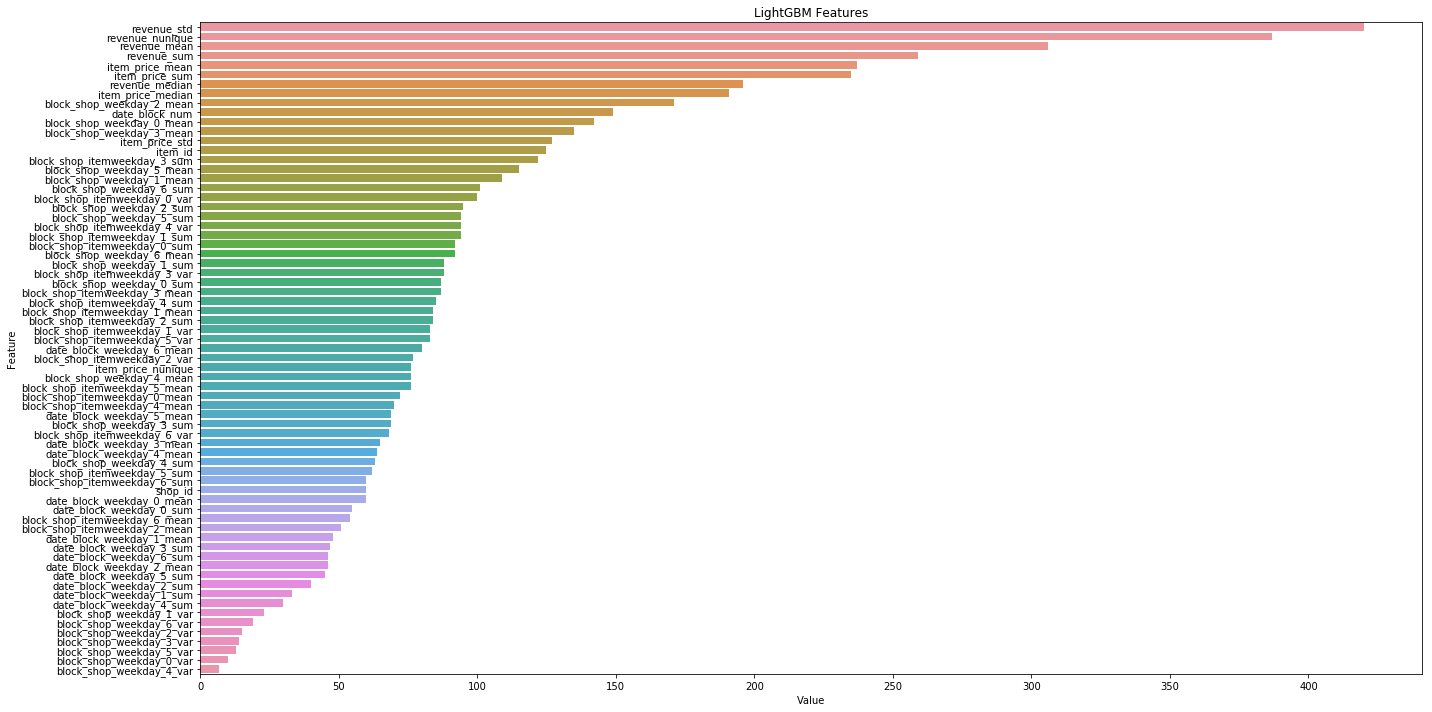

In [21]:
feature_imp = pd.DataFrame(sorted(zip(lgb.feature_importances_, X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

## XGBoost

In [22]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_jobs = -1, n_estimators = 500)

In [23]:
xgb.fit(X_train, y_train ,eval_metric='rmse', eval_set=[(X_train, y_train), (X_valid, y_valid)],
         verbose = 20, early_stopping_rounds=20)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[06:05:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:7.97473	validation_1-rmse:11.8349
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[20]	validation_0-rmse:4.48489	validation_1-rmse:9.9996
[40]	validation_0-rmse:3.96745	validation_1-rmse:9.3374
[60]	validation_0-rmse:3.65953	validation_1-rmse:8.95834
[80]	validation_0-rmse:3.43106	validation_1-rmse:8.59993
[100]	validation_0-rmse:3.27895	validation_1-rmse:8.58826
[120]	validation_0-rmse:3.16561	validation_1-rmse:8.54876
[140]	validation_0-rmse:3.084	validation_1-rmse:8.57032
Stopping. Best iteration:
[120]	validation_0-rmse:3.16561	validation_1-rmse:8.54876



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

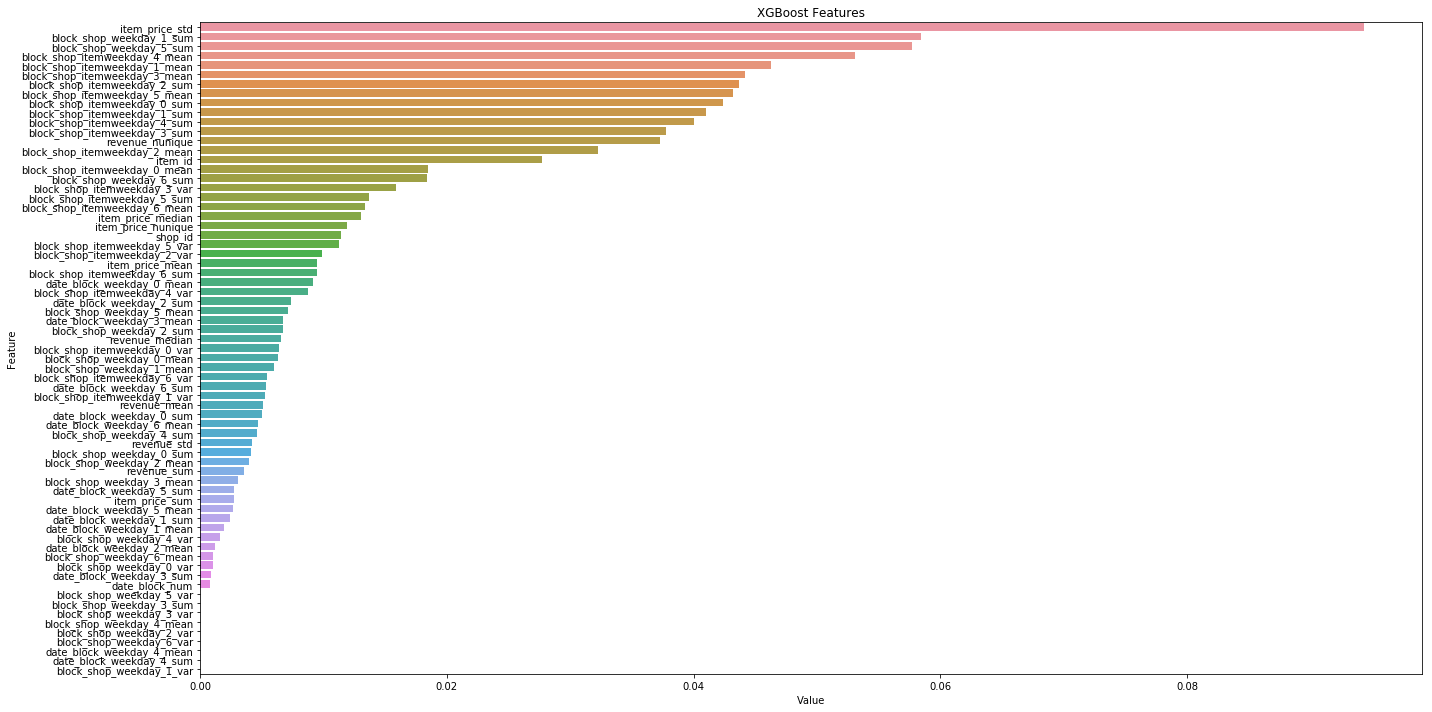

In [24]:
feature_imp = pd.DataFrame(sorted(zip(xgb.feature_importances_, X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('XGBoost Features')
plt.tight_layout()
plt.show()

# Submission

In [25]:
y_pred_lgb = lgb.predict(X_test).clip(0,20)
y_pred_xgb = xgb.predict(X_test).clip(0,20)

In [26]:
sub1 = pd.DataFrame({
    'ID' : test.index,
    'item_cnt_month' : y_pred_lgb
})

sub2 = pd.DataFrame({
    'ID' : test.index,
    'item_cnt_month' : y_pred_xgb
})

sub1.to_csv('20190727_lgb_FE_pred.csv', index = False)
sub2.to_csv('20190727_xgb_Fe_pred.csv', index = False)